# 필요한 모듈을 가져오고 데이터를 로드합니다

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'

In [2]:
# FinanceDataReader로 데이터를 불러옵니다
# 예측할 종목은 한양증권(001750) 입니다

import FinanceDataReader as fdr
STOCK_CODE = '001750'

In [3]:
# 기간은 1년으로 잡았습니다

stock = fdr.DataReader(STOCK_CODE, '2020-02-01', '2021-02-01')

Text(0, 0.5, 'price')

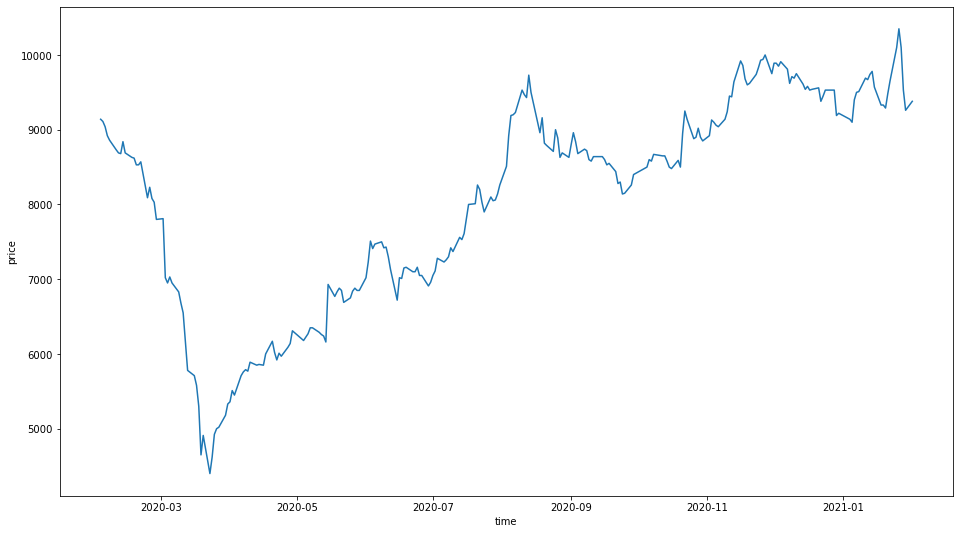

In [4]:
# 학습에 사용될 한양증권 차트입니다

plt.figure(figsize=(16,9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

# Normalization을 진행합니다

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[0.82537068, 0.80536913, 0.81293706, 0.79663866, 0.03296981],
       [0.77594728, 0.75671141, 0.81118881, 0.79159664, 0.0083776 ],
       [0.78583196, 0.76510067, 0.80769231, 0.77983193, 0.01111828],
       ...,
       [0.90280066, 0.88422819, 0.88811189, 0.86218487, 0.06950447],
       [0.84349259, 0.83221477, 0.83391608, 0.81680672, 0.04761135],
       [0.78583196, 0.81208054, 0.82517483, 0.83697479, 0.02615416]])

In [7]:
df = pd.DataFrame(scaled, columns=scale_cols)

# 데이터를 분할하여 훈련 데이터를 생성합니다

In [8]:
# Train과 Test를 분할합니다

from sklearn.model_selection import train_test_split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close',1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [10]:
x_train.shape, y_train.shape

((199, 4), (199,))

In [11]:
x_test.shape, y_test.shape

((50, 4), (50,))

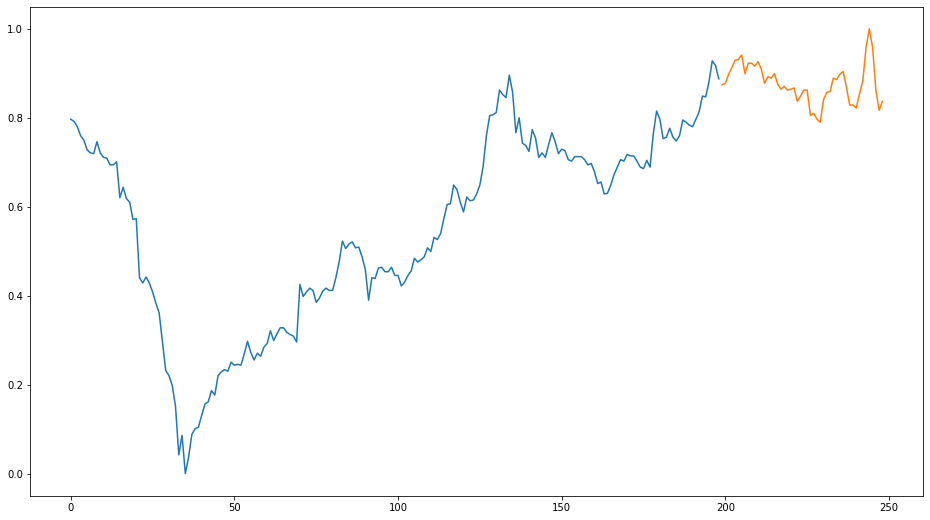

In [12]:
# Train과 Test가 분할된 모습을 차트로 표현했습니다 

plt.figure(figsize=(16,9))
plt.plot(y_train)
plt.plot(y_test)

# TensorFlow 데이터 셋로 데이터 세트 구성합니다

In [13]:
import tensorflow as tf

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [15]:
WINDOW_SIZE = 20
BATCH_SIZE = 32

In [16]:
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [17]:
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


# 딥러닝  네트워크를 학습시킵니다
> 시퀀셜 모델을 활용해서 딥러닝 네트워크를 학습

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential([
    Conv1D(filters=32, kernel_size=5,
          padding="causal",
          activation="relu",
          input_shape=[WINDOW_SIZE, 1]),
    
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [19]:
# loss에는 Huber(), optimizer에는 Adam(), metrics에는 mse를 사용합니다

optimizer = Adam(lr = 0.00001)
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [20]:
# 10번 epoch 동안 val_loss 기준 개선이 없으면 끝나게 설정하였습니다

earlystopping = EarlyStopping(monitor='val_loss', patience=10)
filename = os.path.join('tmp', 'checkpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                            save_weights_only=True,
                            save_best_only=True,
                            monitor='val_loss',
                            verbose=1)

In [21]:
history = model.fit(train_data,
                   validation_data=(test_data),
                   epochs=50,
                   callbacks=[checkpoint, earlystopping])

Epoch 1/50
6/6 [==============================] - 6s 503ms/step - loss: 0.2150 - mae: 0.4151 - val_loss: 0.0980 - val_mae: 0.3093

Epoch 00001: val_loss improved from inf to 0.09804, saving model to tmp\checkpointer.ckpt
Epoch 2/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0229 - mae: 0.1230 - val_loss: 0.0154 - val_mae: 0.1139

Epoch 00002: val_loss improved from 0.09804 to 0.01539, saving model to tmp\checkpointer.ckpt
Epoch 3/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0153 - mae: 0.0919 - val_loss: 0.0189 - val_mae: 0.1285

Epoch 00003: val_loss did not improve from 0.01539
Epoch 4/50
6/6 [==============================] - 0s 25ms/step - loss: 0.0136 - mae: 0.0843 - val_loss: 0.0101 - val_mae: 0.0880

Epoch 00004: val_loss improved from 0.01539 to 0.01012, saving model to tmp\checkpointer.ckpt
Epoch 5/50
6/6 [==============================] - 0s 25ms/step - loss: 0.0104 - mae: 0.0703 - val_loss: 0.0094 - val_mae: 0.0843

Epoch 00005: val_los

In [22]:
model.load_weights(filename)

In [23]:
# test_data를 활용하여 예측을 진행했습니다

pred = model.predict(test_data)

In [24]:
pred.shape

(30, 1)

# Visualize
> 아래의 그래프를 분석해보면 prediction이 실제 차트를 추종하기보다는 그 주변값을 멤도는 완만한 곡선임을 확인할 수 있습니다. model loss는 epoch(반복) 2회에서 극적으로 낮아져 그 이후부터 완만하게 떨어지는 경향을 보이고 있습니다. 다른 모형에서 개선해야할 사항은 prediction이 실제 차트를 추종할 수 있도록 하는 것과 실질적인 model loss를 줄이는 점 등이 있습니다

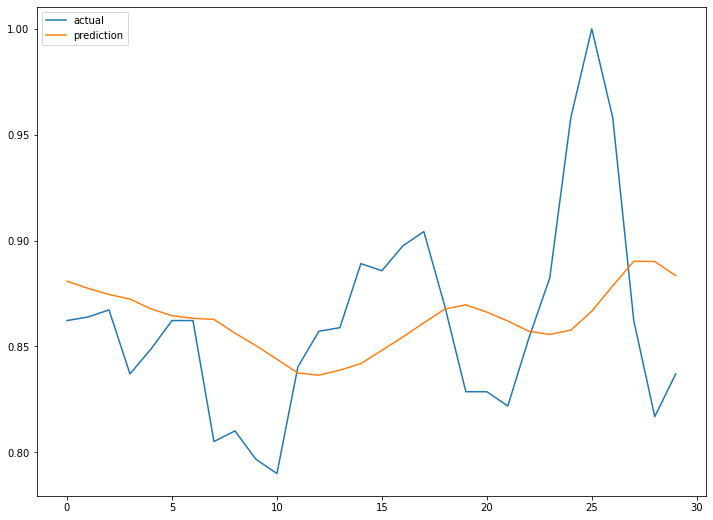

In [25]:
# 예측 데이터는 20일치 데이터로 21일치를 예측합니다. 
# test_data로 예측할 때 앞에 20일은 예측하지 않습니다 

plt.figure(figsize=(12,9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend(loc='upper left')
plt.show()

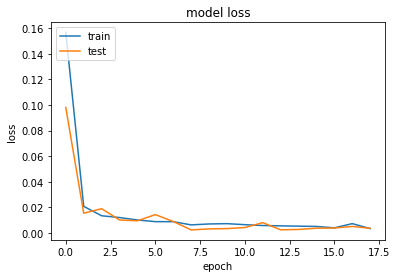

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()